In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Features
Variable | Definition | Key
:-:|:-:|:-:
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class(客舱等级) | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex
Age | Age in years
sibsp | # of siblings / spouses aboard the Titanic(旁系亲属)
parch | # of parents / children aboard the Titanic(直系亲属)
ticket | Ticket number
fare | Passenger fare
cabin | Cabin number(客舱编号)
embarked | Port of Embarkation(上船的港口编号) | C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
train = pd.read_csv("./kaggle/input/titanic/train.csv")
test = pd.read_csv("./kaggle/input/titanic/test.csv")
allData = pd.concat([train, test], ignore_index=True)
# dataNum = train.shape[0]
# featureNum = train.shape[1]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


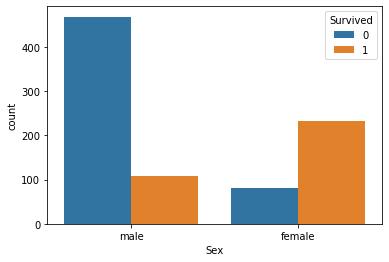

In [4]:
# Sex
sns.countplot('Sex', hue='Survived', data=train)

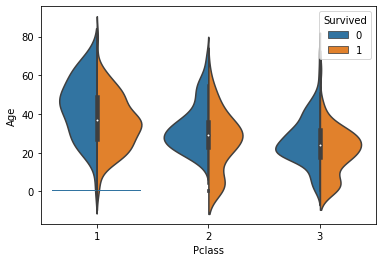

In [5]:
# Pclass
sns.barplot(x='Pclass', y="Survived", data=train)
# Pclass & Age
sns.violinplot("Pclass", "Age", hue="Survived", data=train, split=True)

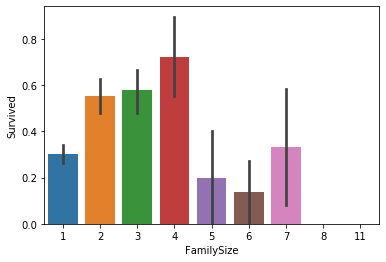

In [6]:
# FamilySize = SibSp + Parch + 1
allData['FamilySize'] = allData['SibSp'] + allData['Parch'] + 1
sns.barplot(x='FamilySize', y='Survived', data=allData)

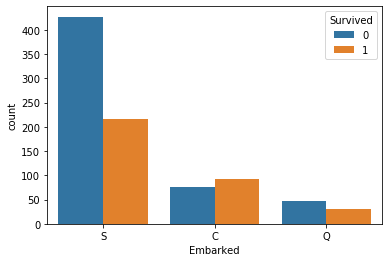

In [7]:
# Embarked
sns.countplot('Embarked', hue='Survived', data=train)

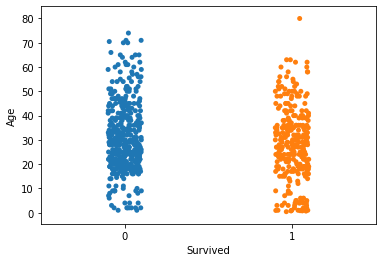

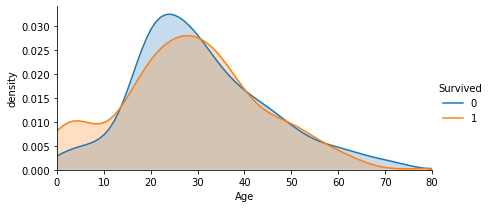

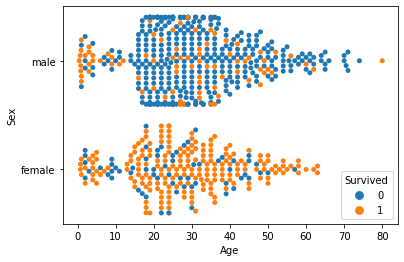

In [8]:
# Age
sns.stripplot(x="Survived", y="Age", data=train, jitter=True)
plt.show()
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('density') 
plt.show()

# Age & Sex
sns.swarmplot(x='Age', y="Sex", data=train, hue='Survived')

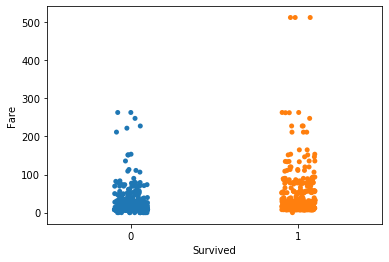

In [9]:
# Fare
sns.stripplot(x="Survived", y="Fare", data=train, jitter=True)

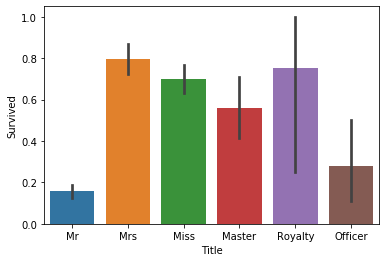

In [10]:
# Name
# allData['Title'] = allData['Name'].str.extract('([A-Za-z]+)\.', expand=False) # str.extract不知道在干嘛
allData['Title'] = allData['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
# pd.crosstab(allData['Title'], allData['Sex'])
TitleClassification = {'Officer':['Capt', 'Col', 'Major', 'Dr', 'Rev'],
                       'Royalty':['Don', 'Sir', 'the Countess', 'Dona', 'Lady'],
                       'Mrs':['Mme', 'Ms', 'Mrs'],
                       'Miss':['Mlle', 'Miss'],
                       'Mr':['Mr'],
                       'Master':['Master','Jonkheer']}
TitleMap = {}
for title in TitleClassification.keys():
    TitleMap.update(dict.fromkeys(TitleClassification[title], title))
    '''
    # cnt = 0
    for name in TitleClassification[title]:
        cnt += allData.groupby(['Title']).size()[name]
    # print (title,':',cnt)
    '''
allData['Title'] = allData['Title'].map(TitleMap)
sns.barplot(x="Title", y="Survived", data=allData)

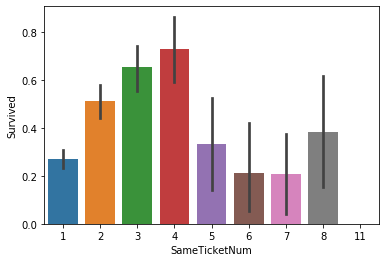

In [11]:
#Ticket
TicketCnt = allData.groupby(['Ticket']).size()
allData['SameTicketNum'] = allData['Ticket'].apply(lambda x:TicketCnt[x])
sns.barplot(x='SameTicketNum', y='Survived', data=allData)
# allData['SameTicketNum']

# 数据清洗
- Sex & Pclass & Embarked --> Ont-Hot
- Age & Fare --> Standardize
- FamilySize & Name & Ticket --> ints --> One-Hot

In [12]:
# Sex
allData = allData.join(pd.get_dummies(allData['Sex'], prefix="Sex"))
# Pclass
allData = allData.join(pd.get_dummies(allData['Pclass'], prefix="Pclass"))
# Embarked
allData[allData['Embarked'].isnull()] # 查看缺失值
allData.groupby(by=['Pclass','Embarked']).Fare.mean() # Pclass=1, Embark=C, 中位数=76
allData['Embarked'] = allData['Embarked'].fillna('C')
allData = allData.join(pd.get_dummies(allData['Embarked'], prefix="Embarked"))

In [13]:
# Age
allData['Child'] = allData['Age'].apply(lambda x:1 if x <= 10 else 0) # 儿童标签
allData['Age'] = (allData['Age']-allData['Age'].mean())/allData['Age'].std() # 标准化
allData['Age'].fillna(value=0, inplace=True) # 填充缺失值
# Fare
allData['Fare'] = allData['Fare'].fillna(25) # 填充缺失值
allData[allData['Survived'].notnull()]['Fare'] = allData[allData['Survived'].notnull()]['Fare'].apply(lambda x:300.0 if x>500 else x)
allData['Fare'] = allData['Fare'].apply(lambda x:(x-allData['Fare'].mean())/allData['Fare'].std())

In [14]:
# FamilySize
def FamilyLabel(s):
    if (s == 4):
        return 4
    elif (s == 2 or s == 3):
        return 3
    elif (s == 1 or s == 7):
        return 2
    elif (s == 5 or s == 6):
        return 1
    elif (s < 1 or s > 7):
        return 0
allData['FamilyLabel'] = allData['FamilySize'].apply(FamilyLabel)
allData = allData.join(pd.get_dummies(allData['FamilyLabel'], prefix="Fam"))

# Name
TitleLabelMap = {'Mr':1.0,
                 'Mrs':5.0,
                 'Miss':4.5,
                 'Master':2.5,
                 'Royalty':3.5,
                 'Officer':2.0}
def TitleLabel(s):
    return TitleLabelMap[s]
# allData['TitleLabel'] = allData['Title'].apply(TitleLabel)
allData = allData.join(pd.get_dummies(allData['Title'], prefix="Title"))

# Ticket
def TicketLabel(s):
    if (s == 3 or s == 4):
        return 3
    elif (s == 2 or s == 8):
        return 2
    elif (s == 1 or s == 5 or s == 6 or s ==7):
        return 1
    elif (s < 1 or s > 8):
        return 0
allData['TicketLabel'] = allData['SameTicketNum'].apply(TicketLabel)
allData = allData.join(pd.get_dummies(allData['TicketLabel'], prefix="TicNum"))

In [15]:
# 清除无用特征
allData.drop(['Cabin', 'PassengerId', 'Ticket', 'Name', 'Title', 'Sex', 'SibSp', 'Parch', 'FamilySize', 'Embarked', 'Pclass', 'Title', 'FamilyLabel', 'SameTicketNum', 'TicketLabel'], axis=1, inplace=True)

# 重新分割数据集
train_data = allData[allData['Survived'].notnull()]
test_data  = allData[allData['Survived'].isnull()]
test_data = test_data.reset_index(drop=True)

xTrain = train_data.drop(['Survived'], axis=1)
yTrain = train_data['Survived']
xTest  = test_data.drop( ['Survived'], axis=1)

# allData.columns.to_list()

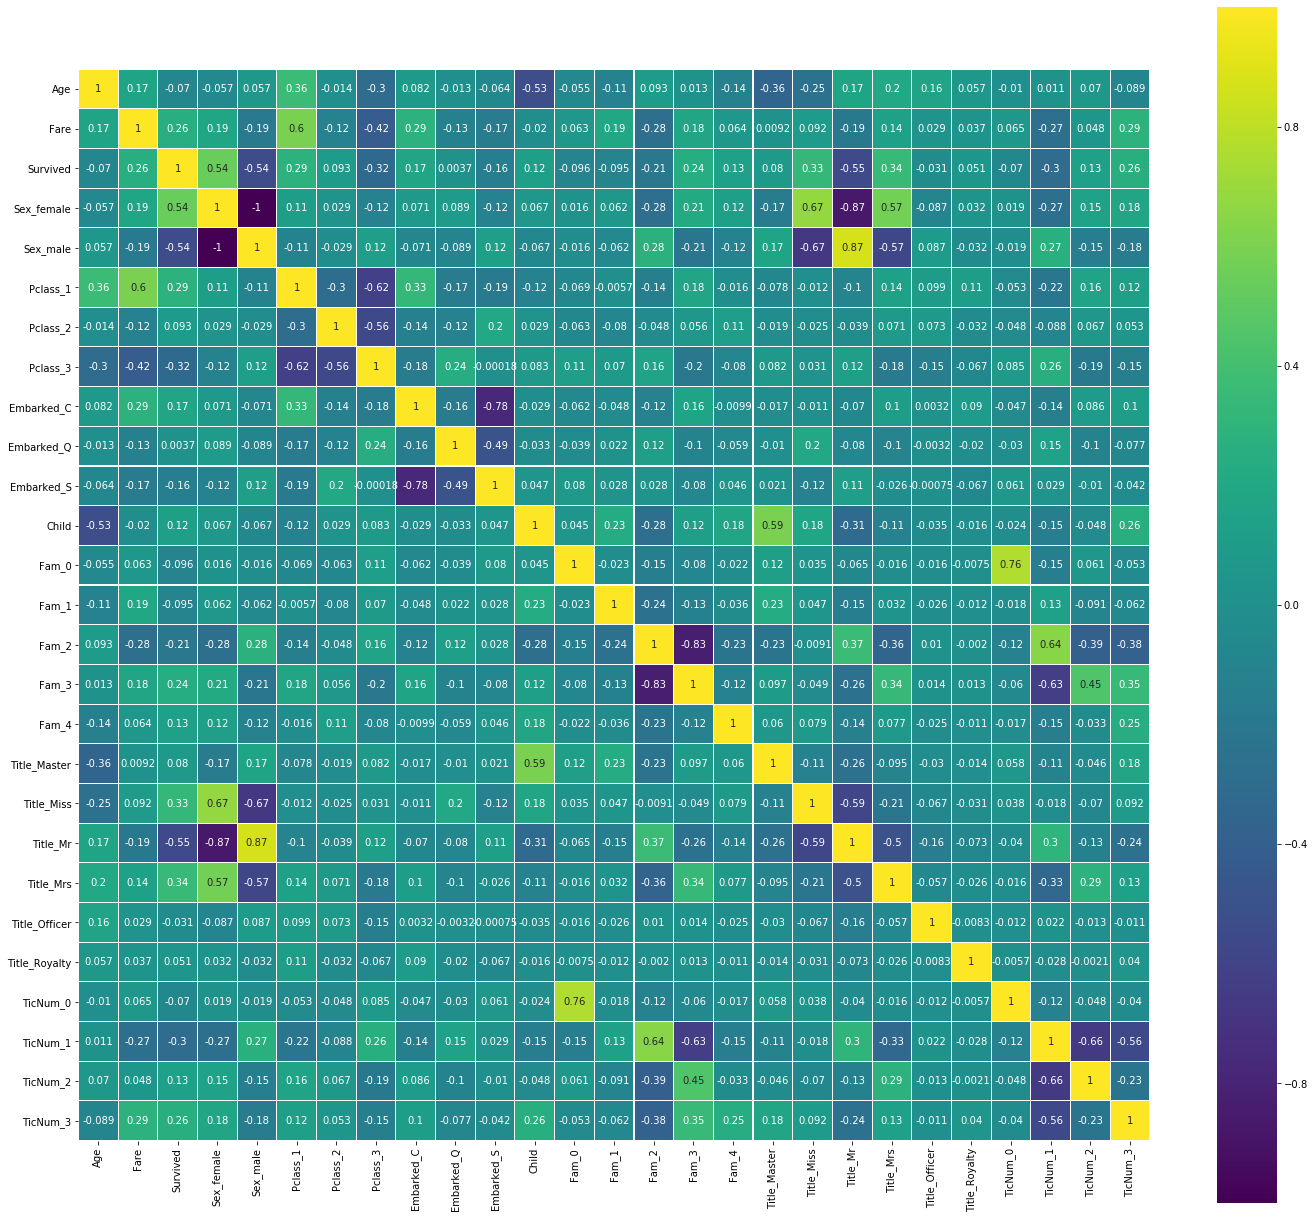

In [16]:
# 特征间相关性分析
Correlation = pd.DataFrame(allData[allData.columns.to_list()])
colormap = plt.cm.viridis
plt.figure(figsize=(24,22))
sns.heatmap(Correlation.astype(float).corr(), linewidths=0.1, vmax=1.0, cmap=colormap, linecolor='white', annot=True, square=True)

# 网格筛选随机森林参数
- n_estimator
- max_depth

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [18]:

pipe = Pipeline([('select', SelectKBest(k=10)),
                 ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])
param_test = {'classify__n_estimators':list(range(20,100,5)),
              'classify__max_depth'   :list(range(3,10,1))}
gsearch = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='roc_auc', cv=10)
gsearch.fit(xTrain, yTrain)
print (gsearch.best_params_, gsearch.best_score_)


{'classify__max_depth': 6, 'classify__n_estimators': 70} 0.8790924679681529


In [19]:
rfc = RandomForestClassifier(n_estimators=70, max_depth=6, random_state=10, max_features='sqrt')
rfc.fit(xTrain, yTrain)
predictions = rfc.predict(xTest)

output = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predictions.astype('int64')})
output.to_csv('my_submission.csv', index=False)